Для решения задачи использовались такие приёмы NLP, как лемматизация, очистка от стоп-слов и токенизация

Для преобразования заголовков в векторы применялся Doc2Vec. Этот метод удобен тем, что все векторы всех текстов имеют одинаковую размерность. 

Для построения моделей и прогнозирования перебирались различные методы (KNN, SVC, Decision Tree, Random Forest, AdaBoost, Gradient Boosting). Результаты предсказания на тестовой выборке, полученные этими моделями, оценивались критерием RMSE

In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import numpy as np 
import pandas as pd

/kaggle/input/kontur-home-assignment/test.tsv
/kaggle/input/kontur-home-assignment/train.tsv


In [2]:
pip install pymorphy2

     |████████████████████████████████| 55 kB 236 kB/s            
     |████████████████████████████████| 8.2 MB 19.3 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install pymorphy2-dicts-ru

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install texthero

     |████████████████████████████████| 24.2 MB 409 kB/s             
     |████████████████████████████████| 1.5 MB 62.7 MB/s            
     |████████████████████████████████| 10.4 MB 49.2 MB/s            
     |████████████████████████████████| 184 kB 16.9 MB/s            
     |████████████████████████████████| 1.0 MB 46.8 MB/s            
  Attempting uninstall: srsly
    Found existing installation: srsly 2.4.2
    Uninstalling srsly-2.4.2:
      Successfully uninstalled srsly-2.4.2
  Attempting uninstall: catalogue
    Found existing installation: catalogue 2.0.6
    Uninstalling catalogue-2.0.6:
      Successfully uninstalled catalogue-2.0.6
  Attempting uninstall: thinc
    Found existing installation: thinc 8.0.15
    Uninstalling thinc-8.0.15:
      Successfully uninstalled thinc-8.0.15
  Attempting uninstall: spacy
    Found existing installation: spacy 3.2.3
    Uninstalling spacy-3.2.3:
      Successfully uninstalled spacy-3.2.3
  Attempting uninstall: nltk
    Found exi

In [5]:
pip install spaCy -U

     |████████████████████████████████| 6.0 MB 287 kB/s            
     |████████████████████████████████| 457 kB 60.9 MB/s            
     |████████████████████████████████| 653 kB 61.1 MB/s            
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.1.1
    Uninstalling typing-extensions-4.1.1:
      Successfully uninstalled typing-extensions-4.1.1
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: thinc
    Found existing installation: thinc 7.4.5
    Uninstalling thinc-7.4.5:
      Successfully uninstalled thinc-7.4.5
  Attempting uninstall: spaCy
    Found existing installation: spacy 2.3.7
    Uninstalling spacy-2.3.7:
      Successfully uninstalled sp

In [6]:
# инструменты для NLP
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import pymorphy2

# чтобы снизить получившуюся размерность после превращения слов в векторы 
import texthero as hero

# инструменты для построения моделей
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

Импортируем данные

In [7]:
data = pd.read_csv('/kaggle/input/kontur-home-assignment/train.tsv', sep = '\t')

**NLP**

Сначала предобработаем строки в наборах данных с помощью лемматизации, а затем токенизации

Для этого сперва создадим объекты классов для лемматизации и превращения слов в векторы

In [8]:
morph = pymorphy2.MorphAnalyzer()
ru_stopwords = stopwords.words('russian')

Удалим из текста знаки препинания

In [9]:
data['title'] = data['title'].str.replace("[^А-ЯЁа-яё0-9 ]", "")

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


Теперь время для лемматизации

In [10]:
def converter(sentence):
    list = []
    words = sentence.split()
    analyzer = pymorphy2.MorphAnalyzer()
    list = map(lambda x: analyzer.parse(x)[0].normal_form, words)
    return ' '.join(list)
data['lemmatized_title'] = data['title'].apply(converter)

и удаления стоп-слов

In [11]:
data['clean_title'] = data['lemmatized_title'].\
                            apply(lambda x: ' '.join([word for word in x.split() if word not in (ru_stopwords)]))

Разделим обработанный текст на отдельные слова-токены

In [12]:
data['tokens'] = data['clean_title'].apply(word_tokenize)

Сформируем из тренировочного набора данных тренировочную и тестовую выборки

In [13]:
is_fake = data['is_fake']
data = data.drop(columns = ['is_fake'])
X_train, X_test, y_train, y_test = train_test_split(data, is_fake, test_size = 0.2)

Создадим пустой "массив слов" и заполним его словами из заголовков

In [14]:
corpus = []
for item in X_train['tokens']:
    for token in item:
        corpus.append([token])

Превратим текст заголовков в векторы

Поскольку анализируем целые заголовки, удобнее использовать Doc2Vec, каждому заголовку будет соответствовать вектор фиксированной размерности
Размерность векторов (vector_size) подбиралась путём ручного перебора в рамках 2-10. Работать с бОльшей размерностью без сжатия tsne неудобно, а с tsne модели хуже (имеют бОльшее значение RMSE). Min count выбран 2, чтобы отсечь слова, встречающиеся лишь однажды и скорее путающие, нежели несущие действительно полезную информацию 

In [15]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
model = Doc2Vec(vector_size=5, min_count=2, epochs = 20)

In [16]:
words = [TaggedDocument(word, 'tag') for word in corpus]
model.build_vocab(words)
model.train(words, total_examples=model.corpus_count, epochs=model.epochs)

In [17]:
card2vec_train = [model.infer_vector((X_train['tokens'][i]))
                  for i in X_train.index]
card2vec_test = [model.infer_vector((X_test['tokens'][i]))
                  for i in X_test.index]

Добавим вектора в датафрейм

Тренировочная и тестовая выборки здесь и далее обрабатываются параллельно, чтобы исключить пропуск какого-либо шага обработки

In [18]:
vectors_train= np.array(card2vec_train).tolist()
vectors_test= np.array(card2vec_test).tolist()
X_train['card2vec'] = vectors_train
X_test['card2vec'] = vectors_test

**Сожмём многомерные данные до двухмерных**

Этот метод можно использовать для визуализации распределения точек-образцов на графике, когда размерность векторов, получаемых с помощью Doc2Vec > 2.
Однако эмпирическим путём выяснено, что на модели в этой работе показывают себя хуже с координатами векторов, полученными tsne, нежели просто с координатами векторами Doc2Vec 

In [19]:
X_train['tsnec2v'] = hero.tsne(X_train['card2vec'])
X_test['tsnec2v'] = hero.tsne(X_test['card2vec'])

In [20]:
X_train = pd.concat([X_train, pd.DataFrame(X_train['card2vec'].to_list(), \
                                                 columns = ['1_2vec', '2_2vec','3_2vec', '4_2vec', '5_2vec'], \
                                                 index = X_train.index)], axis=1)
X_test = pd.concat([X_test, pd.DataFrame(X_test['card2vec'].to_list(), \
                                                 columns = ['1_2vec', '2_2vec','3_2vec', '4_2vec', '5_2vec'], \
                                                 index = X_test.index)], axis=1)
X_train['words_number'] = [len(X_train['tokens'][i])
                  for i in X_train.index]
X_test['words_number'] = [len(X_test['tokens'][i])
                  for i in X_test.index]
X_train['words_average'] = [sum(map(len, X_train['clean_title'][i].split()))/len(X_train['clean_title'][i].split())
                  for i in X_train.index]
X_test['words_average'] = [sum(map(len, X_test['clean_title'][i].split()))/len(X_test['clean_title'][i].split())
                  for i in X_test.index]

Пробовала строить модели, основываясь только на координатах векторов (такой выборке соответствует X_train_2_columns), и с учётом количества слов и средней длины слова в строке (такой выборке соответствует X_train_4_columns). Все методы показывают меньшее значение RMSE на второй выборке

In [21]:
X_train_4_columns = X_train.drop(columns = ['title', 'lemmatized_title', 'clean_title', 'tokens', 'card2vec', 'tsnec2v'])
X_test_4_columns = X_test.drop(columns = ['title', 'lemmatized_title', 'clean_title', 'tokens', 'card2vec', 'tsnec2v'])

In [22]:
X_train_2_columns = X_train.drop(columns = ['title', 'lemmatized_title', 'clean_title', 'tokens',\
                                            'card2vec', 'tsnec2v', 'words_number', 'words_average'])
X_test_2_columns = X_test.drop(columns = ['title', 'lemmatized_title', 'clean_title', 'tokens', \
                                          'card2vec', 'tsnec2v', 'words_number', 'words_average'])

Попробуем перебирать разные методы, от простых к сложным, и посмотрим на оценки разных моделей

Модели оцениваются RMSE 

**KNN** 

Здесь приведена оптимизация количества ближайших соседей при изменении размерности вектора

2-dimens vector, K = 27 => RMSE == 0,276
         
4-dimens vector, K = 40 => RMSE == 0,274        
         
***5-dimens vector, K = 48 => RMSE == 0,267***  лучший вариант, при min_count == 2, K == 41 => RMSE == 0,260
         
6-dimens vector, K = 44 => RMSE == 0,269

8-dimens vector, K = 42 => RMSE == 0,269

10-dimens vector, K = 41 => RMSE == 0.272

Поиск оптимального числа ближайших соседей:

In [23]:
error_rate = []
for i in range(1,50):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train_4_columns,y_train)
    pred_i = knn.predict(X_test_4_columns)
    error_rate.append(np.mean(pred_i != y_test))

Minimum error:- 0.2456597222222222 at K = 42


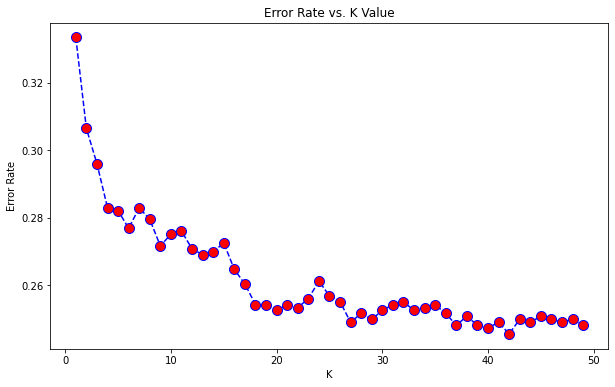

In [24]:
plt.figure(figsize=(10,6))
plt.plot(range(1,50),error_rate,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at K =",req_k_value)

**SVC**

RMSE == 0,47 for X_train_4_columns

     == 0,47 for X_train_2_columns

2-dimensional vector, kernel = rbf => RMSE == 0.273
     
6-dimensional vector, kernel = rbf => RMSE == 0.274

Модель показывала худшую производительность, чем KNN, поэтому RMSE приведены не для всех исследованных размерностей векторов

In [25]:
SVC_model = SVC()

In [26]:
SVC_model.fit(X_train_4_columns, y_train)
SVC_prediction = SVC_model.predict(X_test_4_columns)
mean_squared_error(SVC_prediction, y_test)

0.2517361111111111

In [27]:
kernels = ['linear', 'rbf', 'poly']
for kernel in kernels:
    svc = svm.SVC(kernel=kernel).fit(X_train_4_columns, y_train)
    print(svc.predict(X_test_4_columns))
    print(mean_squared_error(svc.predict(X_test_4_columns), y_test))

[0 1 1 ... 0 1 1]
0.2517361111111111
[0 1 0 ... 0 1 0]
0.2517361111111111
[0 1 1 ... 0 1 0]
0.2526041666666667


**Decision Tree Classifier**

RMSE == 0,39 for X_train_4_columns

RMSE == 0,49 for X_train_2_columns

Аналогично, поскольку RMSE значительно больше не только KNN, но и SVC, они приведены только для примера

In [28]:
clf = DecisionTreeClassifier()
decision_tree_prediction = clf.fit(X_train_4_columns, y_train).predict(X_test_4_columns)
mean_squared_error(decision_tree_prediction, y_test)

0.3394097222222222

**Random Forest Classifier**

2-dim vector: RMSE == 0,31 for X_train_4_columns, RMSE == 0,36 for X_train_2_columns

In [29]:
rfc = RandomForestClassifier()
rfc_prediction = rfc.fit(X_train_4_columns, y_train).predict(X_test_4_columns)
mean_squared_error(rfc_prediction, y_test)

0.2699652777777778

**Ada Boost Classifier**

64-dimens vector, tse

optimal n estimators is 7, optimal learning rate = 0.51 => RMSE == 0,264 for X_train_4_columns

optimal n estimators is 30, optimal learning rate = 0.99 => RMSE == 0,61 for X_train_2_columns

2-dim vector, n_estimators=9,learning_rate=0.47 => RMSE == 0,268 for X_train_4_columns

6-dim vector, n_estimators=10,learning_rate=0.68 => RMSE == 0,268 for X_train_4_columns


Оптимальные параметры находились перебором в ограниченных рамках

In [30]:
error_rate = []
for i in range(1,100):
    ab = AdaBoostClassifier(n_estimators=53, learning_rate=i/100)
    ab.fit(X_train_4_columns,y_train)
    pred_i = ab.predict(X_test_4_columns)
    error_rate.append(np.mean(pred_i != y_test))

Minimum error:- 0.24739583333333334 at setting = 89


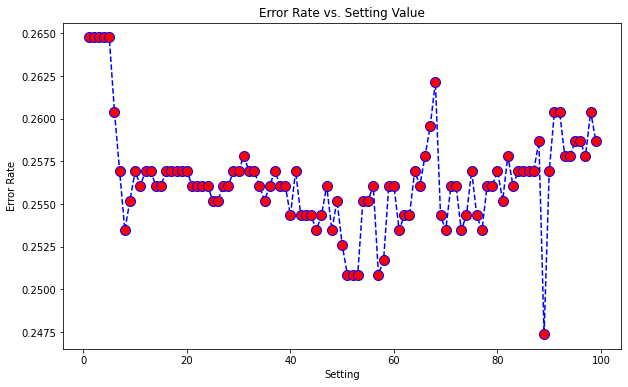

In [31]:
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Setting Value')
plt.xlabel('Setting')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at setting =",req_k_value)

**GDB**

Здесь RMSE совпадает с Ada с точностью до второго знака, поэтому точные данные не приводятся

In [32]:
error_rate = []
for i in range(1,100):
    gdb = GradientBoostingClassifier(n_estimators=10, learning_rate = i/100,max_depth = 1, random_state = 0)
    gdb.fit(X_train_4_columns,y_train)
    pred_i = gdb.predict(X_test_4_columns)
    error_rate.append(np.mean(pred_i != y_test))

Minimum error:- 0.2465277777777778 at setting = 46


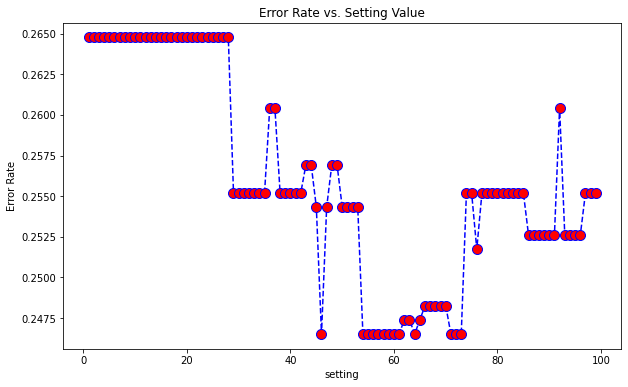

In [33]:
plt.figure(figsize=(10,6))
plt.plot(range(1,100),error_rate,color='blue', linestyle='dashed',marker='o',markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. Setting Value')
plt.xlabel('setting')
plt.ylabel('Error Rate')
req_k_value = error_rate.index(min(error_rate))+1
print("Minimum error:-",min(error_rate),"at setting =",req_k_value)

При подобранных параметрах простые модели (KNN, например) не уступают более сложным моделям, параметры которых оптимизировать труднее. Поэтому при RMSE, отличающемся во втором-третьем знаке после запятой, имеет смысл предпочесть более простой и понятный метод 

На графике можно увидеть распределение точек, соответствующих истинным и фэйковым новостям 

Правда, стоит подставлять координаты двухмерного вектора, полученные либо сразу doc2vec, либо tsne

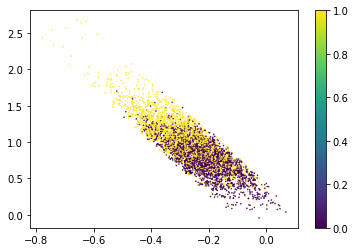

In [34]:
plt.scatter(X_train['1_2vec'], X_train['2_2vec'],\
            c=y_train, s = 0.3)
plt.colorbar()